In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statistics import mean
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, cross_validate, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer, fbeta_score
from sklego.preprocessing import InformationFilter
from sklego.metrics import p_percent_score, equal_opportunity_score

In [3]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklego.linear_model import DemographicParityClassifier

In [8]:
# column names
cols = ['existing_checking', 'duration(months)', 'credit_history', 'purpose', 'credit_amount',
         'savings_account', 'employment_since', 'installment_rate', 'status_and_sex', 'other_debtors',
         'residence_since', 'property', 'age', 'other_installment_plans', 'housing',
         'existing_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'classification']

In [5]:
# load data
df_orig = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data", names= cols, delimiter=' ')

In [7]:
df_orig.head(10)

,existing_checking,duration(months),credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,status_and_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [9]:
# numerical features
num_features = ['credit_amount', 'duration(months)', 'installment_rate', 'residence_since', 'age',
           'existing_credits', 'people_liable']

In [10]:
# categorical features
cat_features = ['existing_checking', 'credit_history', 'purpose', 'savings_account', 'employment_since',
            'other_debtors', 'property', 'other_installment_plans', 'housing', 'job',
           'telephone', 'foreign_worker']

In [13]:
# make copy of original df so that further tranformations won't change original df
df_transformed = df_orig.copy()

# normalize numerical features
df_transformed[num_features] = StandardScaler().fit_transform(df_transformed[num_features])

## Feature Engineering: Attribute 9

### Reference for Attribute 9:
```
Attribute 9: (qualitative)
Personal status and sex
A91 : male : divorced/separated
A92 : female : divorced/separated/married
A93 : male : single
A94 : male : married/widowed
A95 : female : single 
```

Given that we're treating gender as the sensitive varibale, we decided to separate 
attribute 9 (sex_and_status) into two distinct variables: 1. gender 2. personal_status.
Isolating the gender variable allows us to build a model with a fairness constraint on gender

In [15]:
# create gender column and personal_status column
df_transformed['gender'] = np.nan
df_transformed['personal_status'] = np.nan

In [17]:
# separate attribute 9 (sex_and_status) into two columns: gender, personal_status
for index, row in df_transformed.iterrows():
    if row['status_and_sex'] == 'A91':
        # male
        df_transformed.loc[index, 'gender'] = 0

        # divorced/separated
        df_transformed.loc[index, 'personal_status'] = 1

        #print('mutated row = ', df.iloc[index])
    if row['status_and_sex'] == 'A92':
        # female
        df_transformed.loc[index, 'gender'] = 1
        # divorced/separated/married
        df_transformed.loc[index, 'personal_status'] = 1

    if row['status_and_sex'] == 'A93':
        # male
        df_transformed.loc[index, 'gender'] = 0
        # single
        df_transformed.loc[index, 'personal_status'] = 0

    if row['status_and_sex'] == 'A94':
        # male
        df_transformed.loc[index, 'gender'] = 0
        # married/widowed
        df_transformed.loc[index, 'personal_status'] = 1

    if row['status_and_sex'] == 'A95':
        # female
        df_transformed.loc[index, 'gender'] = 1
        # single
        df_transformed.loc[index, 'personal_status'] = 0

In [18]:
# gender, personal_status column after feature engineering transformation
df_transformed[['gender', 'personal_status']].head(6)

,gender,personal_status
0,0.0,0.0
1,1.0,1.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0


In [19]:
# now that we've separated sex_status into two columns, we can now delete the sex_status column
df_transformed = df_transformed.drop('status_and_sex', axis=1)

In [20]:
# one-hot encoding each of every categorical features
df_transformed = pd.get_dummies(df_transformed, columns = cat_features)

In [21]:
# replace labels with 1=pos, 0=neg
df_transformed.classification.replace([1,2], [1,0], inplace=True)

In [22]:
# define x as all columns except for last column which contains labels
x = df_transformed.drop('classification', axis = 1)

In [23]:
y = df_transformed.classification

In [29]:
# 80/20 split for train/test
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 0)

## Initial Modeling

To begin our model experiments, we used the Logistic Regression classifier from scikit-learn to build our initial model without a fairness constraint. Next, in order to follow the demographic parity measure of fairness to build a model with a fairness constraint, we used the Demographic Parity Classifier from the scikit-lego python module. This classifier is built as an extension of basic logistic regression with the addition of a fairness constraint applied to protected variable(s).  That is, scikit-lego's Demographic Parity Classifier maps feature vectors $x_i$ to class labels $y_i$ using the same probability distribution as logisitic regression:
\begin{gather}
\operatorname{P}(y_i=1|x_i,\theta) = \frac{1}{1+e^{-\theta^Tx_i}}
\end{gather}
Furthermore, $\theta$, the estimated parameter vector, is obtained using Maximum Likelihood Estimation, just as with logistic regression:
\begin{gather}
\operatorname{arg,min}_\theta = -\sum_{i=1}^N \log\ \operatorname{P}(y_i|x_i, \theta)
\end{gather}
The only difference is that the Demographic Parity Classifier adds the following constraint to the above optimization problem. 
\begin{gather}
\text{minimize}\ -\sum_{i=1}^N \log\ \operatorname{P}(y_i|x_i, \theta) \\
\text{subject to}\  \operatorname{Cov}(z, d_\theta(x)) \leq c \\
\operatorname{Cov}(z, d_\theta(x))  \geq -c
\end{gather}

% $$\text{subject to}\  \frac{1}{N} \sum_{i=1}^N (z_i - \overline{z})\theta^T x_i \leq c,  \frac{1}{N} \sum_{i=1}^N (z_i - \overline{z})\theta^T x_i \geq -c$$
Where $z$ is the protected variable, and $d_\theta(x)$ is the signed distance from feature vectors to the decision boundary. Furthermore, $c$ is a covariance threshold, ranging from 0 to 1, specifying a limit for accepted covariance between protected variable and signed distance from feature vectors to the decision boundary. 

In [30]:
# define cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [31]:
# model evaluation metrics 
mean_accuracy=[]
mean_precision=[]
mean_recall=[]
accuracy_std=[]
p_percents=[]

In [32]:
# classifiers
classifiers=['Logistic Regression clf', 'Demographic Parity clf (cov_threshold=0)']
models=[LogisticRegression(max_iter=5000), DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=0.0)]

In [33]:
for model in models:
    # accuracy
    cv_accuracy = cross_val_score(model,x,y,scoring = "accuracy", cv = cv, n_jobs=-1)
    # precision
    cv_precision = cross_val_score(model, x, y, scoring='precision', cv=cv, n_jobs=-1)
    # recall
    cv_recall = cross_val_score(model, x, y, scoring='recall', cv=cv, n_jobs=-1)
    #p% 
    model.fit(xtrain, ytrain)
    p_percent = p_percent_score(sensitive_column="gender")(model, xtest)


    mean_accuracy.append(mean(cv_accuracy))
    accuracy_std.append(cv_accuracy.std())
    mean_precision.append(mean(cv_precision))
    mean_recall.append(mean(cv_recall))
    p_percents.append(p_percent)

In [34]:
models_dataframe=pd.DataFrame({'Mean Accuracy':mean_accuracy, 'Accuracy Std':accuracy_std, 'Mean precision':mean_precision, 'Mean recall':mean_recall, 'P%':p_percents},index=classifiers)

### Benchmark Results

In [35]:
df_transformed['gender'].value_counts()

0.0    690
1.0    310
Name: gender, dtype: int64

In [37]:
df_transformed.groupby(['gender','classification']).size()

gender  classification
0.0     0                 191
        1                 499
1.0     0                 109
        1                 201
dtype: int64

In [40]:
df_transformed['classification'].value_counts()

1    700
0    300
Name: classification, dtype: int64

Baseline comparison for p% relative to gender: If our model was 100% accurate, the following would be our p% score with gender as sensitive variable:

In [38]:
# positive outcome male / total male 
p_y1_z0 = 499/690
# positive outcome female / total female
p_y1_z1 = 201/310
dataset_p_percent = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
dataset_p_percent

0.8965673282047968

Baseline comparison for accuracy: if our model only predicted loan approval (majority outcome class), our accuracy would be 700/1000 = 0.7

In [41]:
baseline_dataframe = pd.DataFrame({'Baseline accuracy': [0.7], 'Baseline p%': [0.8966]}, index=['Baseline'])
baseline_dataframe

,Baseline accuracy,Baseline p%
Baseline,0.7,0.8966


In [42]:
models_dataframe

,Mean Accuracy,Accuracy Std,Mean precision,Mean recall,P%
Logistic Regression clf,0.750,0.031198,0.795016,0.867143,0.916491
Demographic Parity clf (cov_threshold=0),0.748,0.030210,0.791543,0.870000,0.975256


# Exploration of covariance threshold: Demographic Parity Classifier 

## Approach 1:  Exploring how feature importance changes as a function of p% (fairness score) for gender 
### (measuring feature importance as abs(feature weight) * average absolute value of that feature's column)

Our first approach for diagnosing the source(s) of fairness violations was to investigate how each feature's 'influence' on outcome predictions changed as a function of $p\%$ score, i.e., fairness score. It's important to note that we are measuring how much 'influence' a feature has on the outcome predictions by multiplying the absolute value of a feature's learned coefficient by the average absolute value of that feature's column. That is, we are not taking the sign of the coefficient into consideration, rather, we are measuring the overall magnitude of a feature's 'influence' on outcome predictions without considering whether that feature's influence is pushing the classification towards the positive outcome or the negative outcome. Furthermore, the reason for multiplying the learned coefficient by the average absolute value is to account for the fact that feature's that are binary variables will require a larger coefficient than feature's with a large range of values in order to have the same influence on the final outcome. That is, multiplying the learned coefficient by the average absolute value makes the 'influence' of binary variables and variables with greater ranges of values more comparable.

NOTE: we will be referring to this measure of a feature's 'influence' on outcome predictions as 'feature importance' for the duration of this approach.

We will accomplsih this approach by training 60 different demographic parity classifier models, each with a different covariance thresholds between 0-1  in order to achieve a wide range of fairness scores. We will then plot out how 'feature importance' changes as a function of fairness.

In [46]:
dpc = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=1)

In [47]:
# The specified sensitive column of a demographic parity classifier does not receive a coefficient during training,
# therefore, our features for the demographic parity classfier will exclude our protected variable, gender.
dpc_features = x.columns.drop('gender')

In [60]:
# create dictionary where keys are features, and values are an empty list (to be populated later on)
feature_dict = {}
for feat in dpc_features:
    feature_dict[feat] = []

In [49]:
cov_threshold = np.linspace(0,1,60)

In [51]:
# build demographic parity models with 60 different covariance thresholds, storing each corresponding
# feature coefficient in the above dictionary, allowing us to see how each feature's coefficients change as a function
# of covariance threshold 
for cov in cov_threshold:
    model = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=cov)
    model.fit(x, y)
    p_percent = p_percent_score(sensitive_column="gender")(model, x)
    for coef, feat in zip(model.coef_[0,:],dpc_features):
        feature_dict[feat].append([cov,abs(coef)*abs(df_transformed[feat].mean()),p_percent])

In [52]:
# format = {'feature x': [covariance threshold, feature x importance, p_percent]}
# example:
feature_dict['residence_since'][0]

[0.0, 6.9000057198361416e-18, 0.9892473118279569]

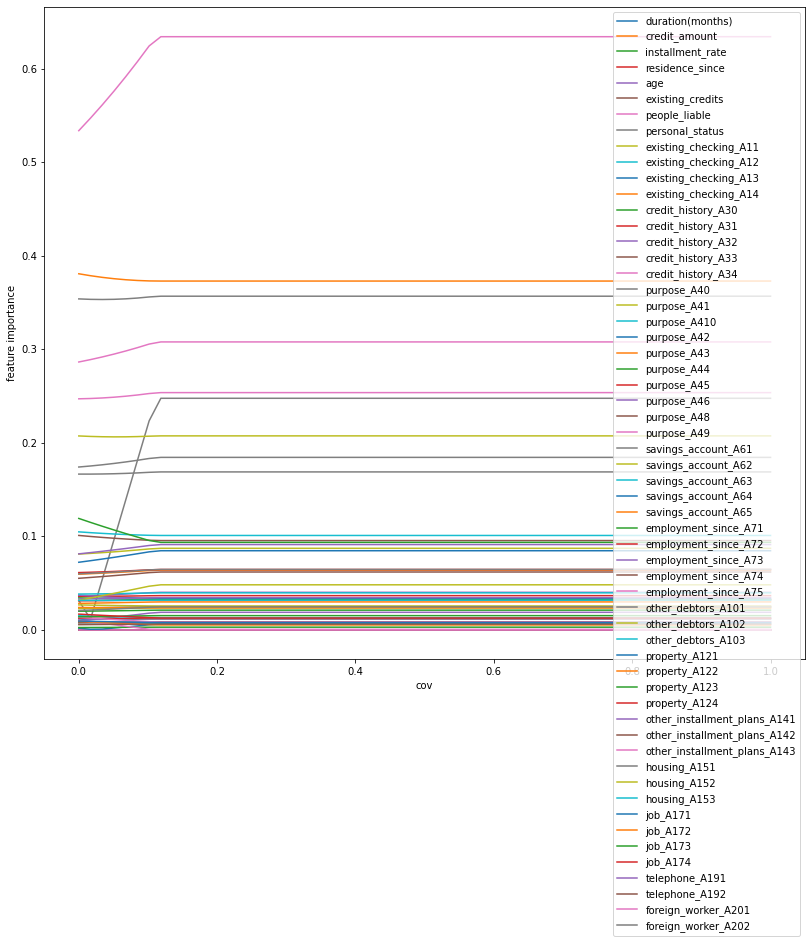

In [53]:
plt.figure(figsize=(30,12))
plt.subplot(121)

for feature in feature_dict:
    xs = [x[0] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
plt.xlabel("cov")
plt.ylabel('feature importance')
plt.legend()

In the above plot, we see that feature importance is flatlining slightly before a covariance threshold of 0.2. For this reason we will run the above analysis again with covariance threshold values ranging from 0-0.2.

In [61]:
cov_threshold = np.linspace(0.0,0.2, 30)

In [62]:
for cov in cov_threshold:
    model = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=cov)
    model.fit(x, y)
    p_percent = p_percent_score(sensitive_column="gender")(model, x, y)
    for coef, feat in zip(model.coef_[0,:],dpc_features):
        feature_dict[feat].append([cov,abs(coef)*abs(df_transformed[feat]).mean(),p_percent])

In [63]:
# format = {'feature': [covariance threshold, feature importance, p_percent]}
feature_dict['foreign_worker_A201'][0]

[0.0, 0.5337773020689963, 0.9892473118279569]

In [64]:
df_list = []
delta_list = []
for feature in feature_dict:
    df = pd.DataFrame(data = feature_dict[feature], columns = ["cov", f"{feature}_importance", "p percent"])
    df.sort_values('p percent')
    df = df.reset_index(drop=True)
    most_fair = df.at[0,f"{feature}_importance"]
    least_fair = df.at[29, f"{feature}_importance"]
    fairness_delta = most_fair - least_fair
    delta_list.append(fairness_delta)
    
feature_fairness_delta = list(zip(feature_dict.keys(),delta_list))
feature_fairness_delta_sort = sorted(feature_fairness_delta, key=lambda x : x[1])

features = []
delta_importance = []
for item in feature_fairness_delta_sort:
    features.append(item[0])
    delta_importance.append(item[1])

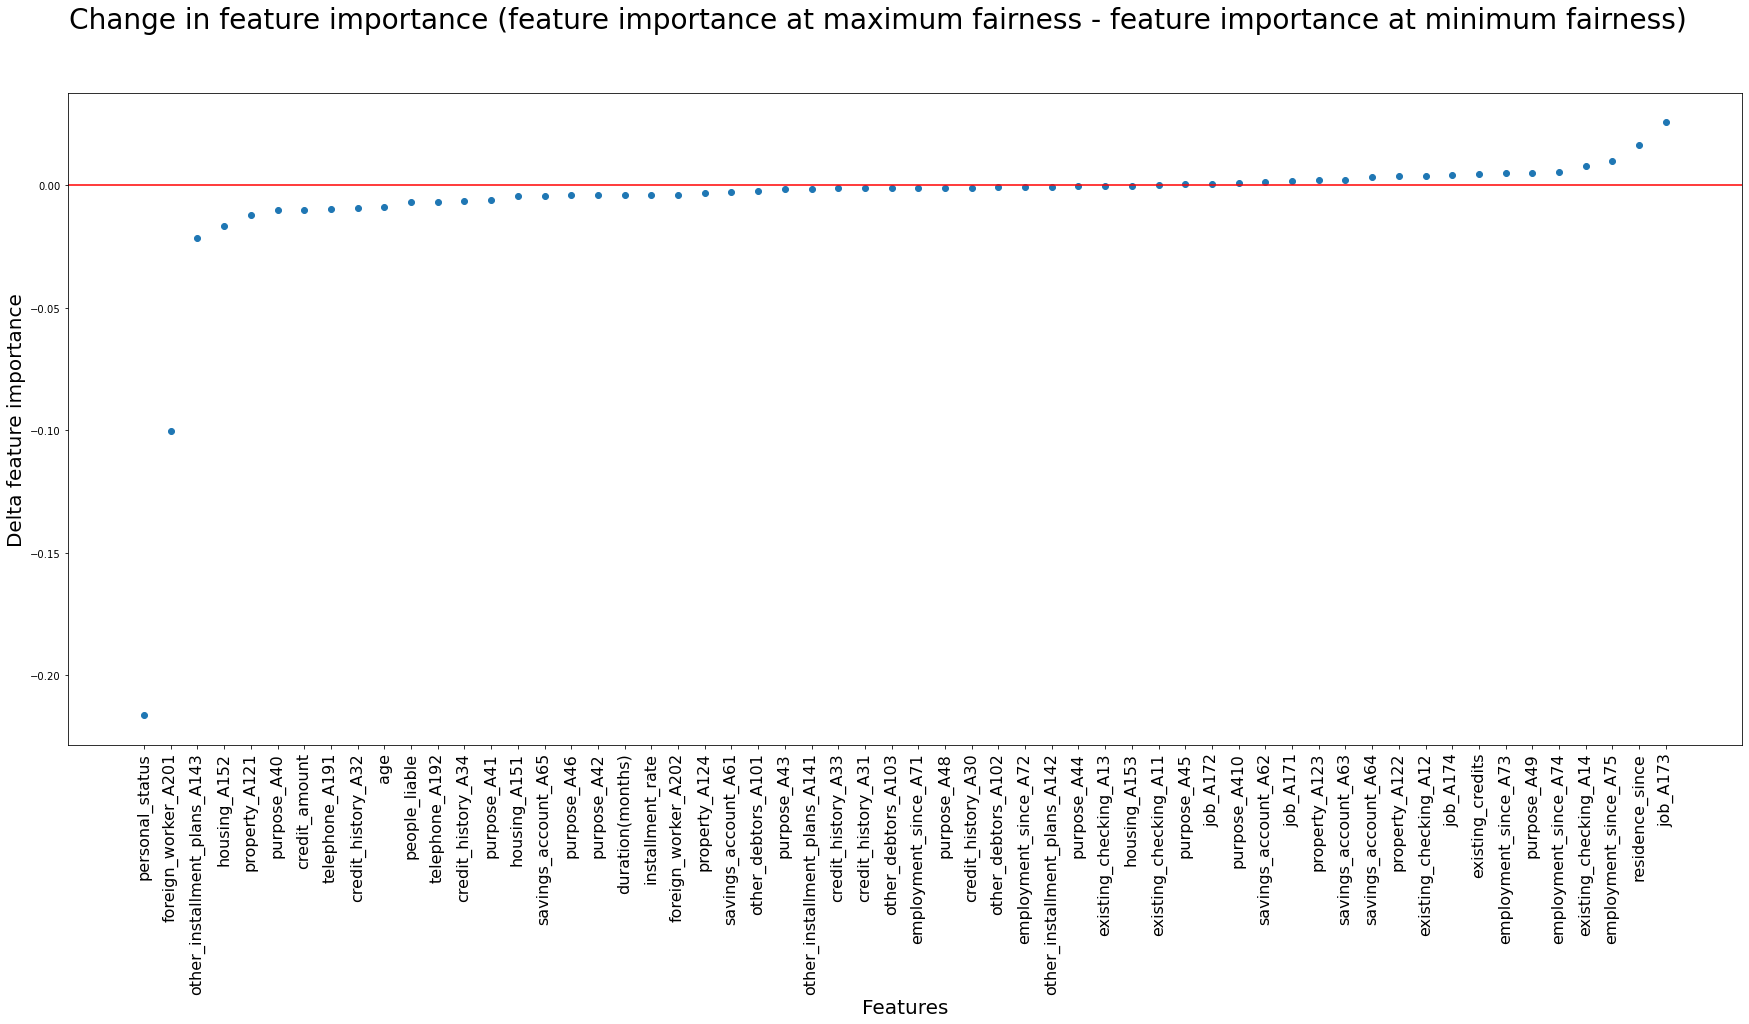

In [65]:
figure, ax = plt.subplots(figsize=(30,12))
ax.scatter(features, delta_importance)
xticks_labels = features
ax.set_xticklabels(xticks_labels, rotation=90, fontsize=16)
figure.suptitle('Change in feature importance (feature importance at maximum fairness - feature importance at minimum fairness)', fontsize=28)
plt.xlabel("Features", fontsize=20)
plt.ylabel('Delta feature importance', fontsize=20)
ax.axhline(y=0, color="red")
plt.show()

We see that personal_status and foreign_worker_A201 are the two features whose magnitude of feature importance exhibited the greatest decrease relative to p%. Below is a plot of exactly how these two feature's importance changed as a function of p%.

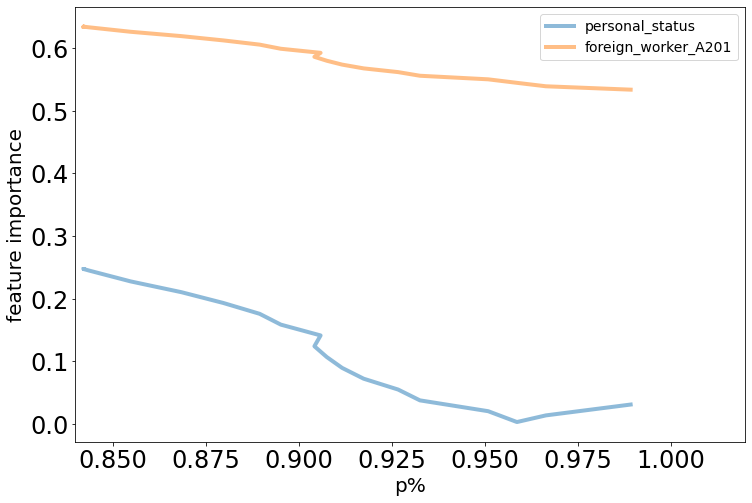

In [66]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12,8))

for feature in ['personal_status', 'foreign_worker_A201']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    ax.plot(xs,ys,alpha=0.5, label=feature, linewidth=4)

plt.xlabel("p%")
plt.ylabel('feature importance', fontsize=20)
plt.xlim((0.84, 1.02))
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
ax.legend(prop={'size':14})
ax.set_xlabel("p%", fontsize=20)
ax.set_ylabel("feature importance")
ax.tick_params(labelbottom=True)

We see that personal status exhibited the greatest change in feature influence, decreasing from $0.2475$ at a $p\%$ score of $0.842$, to $0.03$ at a $p\%$ score of $0.989$. The magnitude of feature influence for Foreign Worker A201, which indicates that the individual is a foreign worker, decreased from 0.634 at a $p\%$ score of 0.842, to 0.5338 at a $p\%$ score of 0.989. Given that $p\%$ is increasing as magnitude of feature influence is decreasing for these features, these results suggest that personal status and foreign worker A201 are contributing to fairness violations.

One potential reason that there were only two features that exhibited measurable change in feature influence relative to $p\%$ is the fact that the baseline $p\%$ for the dataset, mentioned in initial model benchmarks, was quite high at 0.8966.

## Approach 2: Fairness Decomposition based on Model Difference Regression

As shown in the above benchmark results, we have two different logistic regression models which achieved measurably different $p\%$ scores relative the protected variable, gender. For the purposes of explaining this approach, we will refer to the logistic regression model without fairness constraint as the unfair model, and the logistic regression model with a maximal fairness constraint applied to gender (Demographic Parity Classifier with covariance threshold of 0) as the fair model.  Please note that 'fair' and 'unfair' are specifically referring to the demographic parity measure of fairness.

The goal of this approach was to build a decomposition model that models the difference between the fair model and the unfair model. We accomplished this by modeling the log odds of the fair model using the log odds of the unfair model and the original predictors from the data. That is, our decomposition model took the form of:


$$log\ odds_{fair} \sim log\ odds_{unfair} + \beta_0 + \beta_1\cdot x_1 + \beta_2\cdot x_2 + \cdots + \beta_n \cdot x_n$$
which is equivalent to:
$$log\ odds_{fair} - log\ odds_{unfair} \sim \beta_0 + \beta_1\cdot x_1 + \beta_2\cdot  x_2 + \cdots + \beta_n\cdot x_n$$


Because our decomposition model is modeling the difference between a fair model and an unfair model, we can use the learned coefficients of the decomposition model, factoring in the average difference in feature values between females and males, to evaluate which features were contributing the most to the difference in $p\%$ scores for the unfair and fair models. This evaluation metric took the following form:


x_1  :           $\beta_1$  *  [  Mean( $x_1$ | z = 0)  -  Mean(  $x_1$  | z = 1)  ]

x_2  :           $\beta_2$  *  [  Mean( $x_2$ | z = 0)  -  Mean(  $x_2$  | z = 1)  ]

...

x_n  :           $\beta_n$  *  [  Mean( $x_n$ | z = 0)  -  Mean(  $x_n$  | z = 1)  ]

where 
$\beta_i$ is the learned feature coefficient for feature $x_i$ in the decomposition model, and 
$z$ is the binary protected variable.

In [67]:
unfair_model = LogisticRegression(max_iter=5000)
fair_model = DemographicParityClassifier(sensitive_cols=['gender'], covariance_threshold=0)

In [68]:
# remove protected variable column (gender) prior to training for unfair model
x_decomp = x.drop('gender', axis=1)

In [69]:
unfair_model.fit(x_decomp,y)
fair_model.fit(x,y)

OneVsRestClassifier(estimator=_DemographicParityClassifier(covariance_threshold=0,
                                                           sensitive_cols=['gender']),
                    n_jobs=1)

In [70]:
beta_transpose_unfair = np.transpose(unfair_model.coef_)
beta_transpose_fair = np.transpose(fair_model.coef_)

In [71]:
log_odds_unfair = x_decomp @ beta_transpose_unfair
log_odds_fair = x_decomp @ beta_transpose_fair

In [72]:
y_mod_diff = log_odds_fair - log_odds_unfair

In [73]:
model_difference = LinearRegression()

In [74]:
model_difference.fit(x_decomp, y_mod_diff)

LinearRegression()

In [75]:
feat_dict = {}
for feat in x_decomp.columns:
    feat_dict[feat] = []

In [76]:
for coef, feat in zip(model_difference.coef_[0,:], x_decomp.columns):
    # [Mean( x_n | z = 0) - Mean( x_n | z = 1)]
    mean_feat_given_class_diff = df_transformed[feat].loc[df_transformed['gender'] == 0].mean() - df_transformed[feat].loc[df_transformed['gender'] == 1].mean()
    feat_dict[feat].append(coef*mean_feat_given_class_diff)

In [79]:
mod_diff_df = pd.DataFrame.from_dict(feat_dict, orient='index', columns=['feature contribution'])
sorted_diff = mod_diff_df.sort_values(by=['feature contribution'], ascending=True)

In [80]:
sorted_diff

,feature contribution
personal_status,-0.470465
employment_since_A75,-0.006789
housing_A152,-0.004557
purpose_A49,-0.004453
job_A171,-0.003837
age,-0.003331
savings_account_A64,-0.003175
existing_credits,-0.002844
job_A174,-0.002239
employment_since_A72,-0.002119


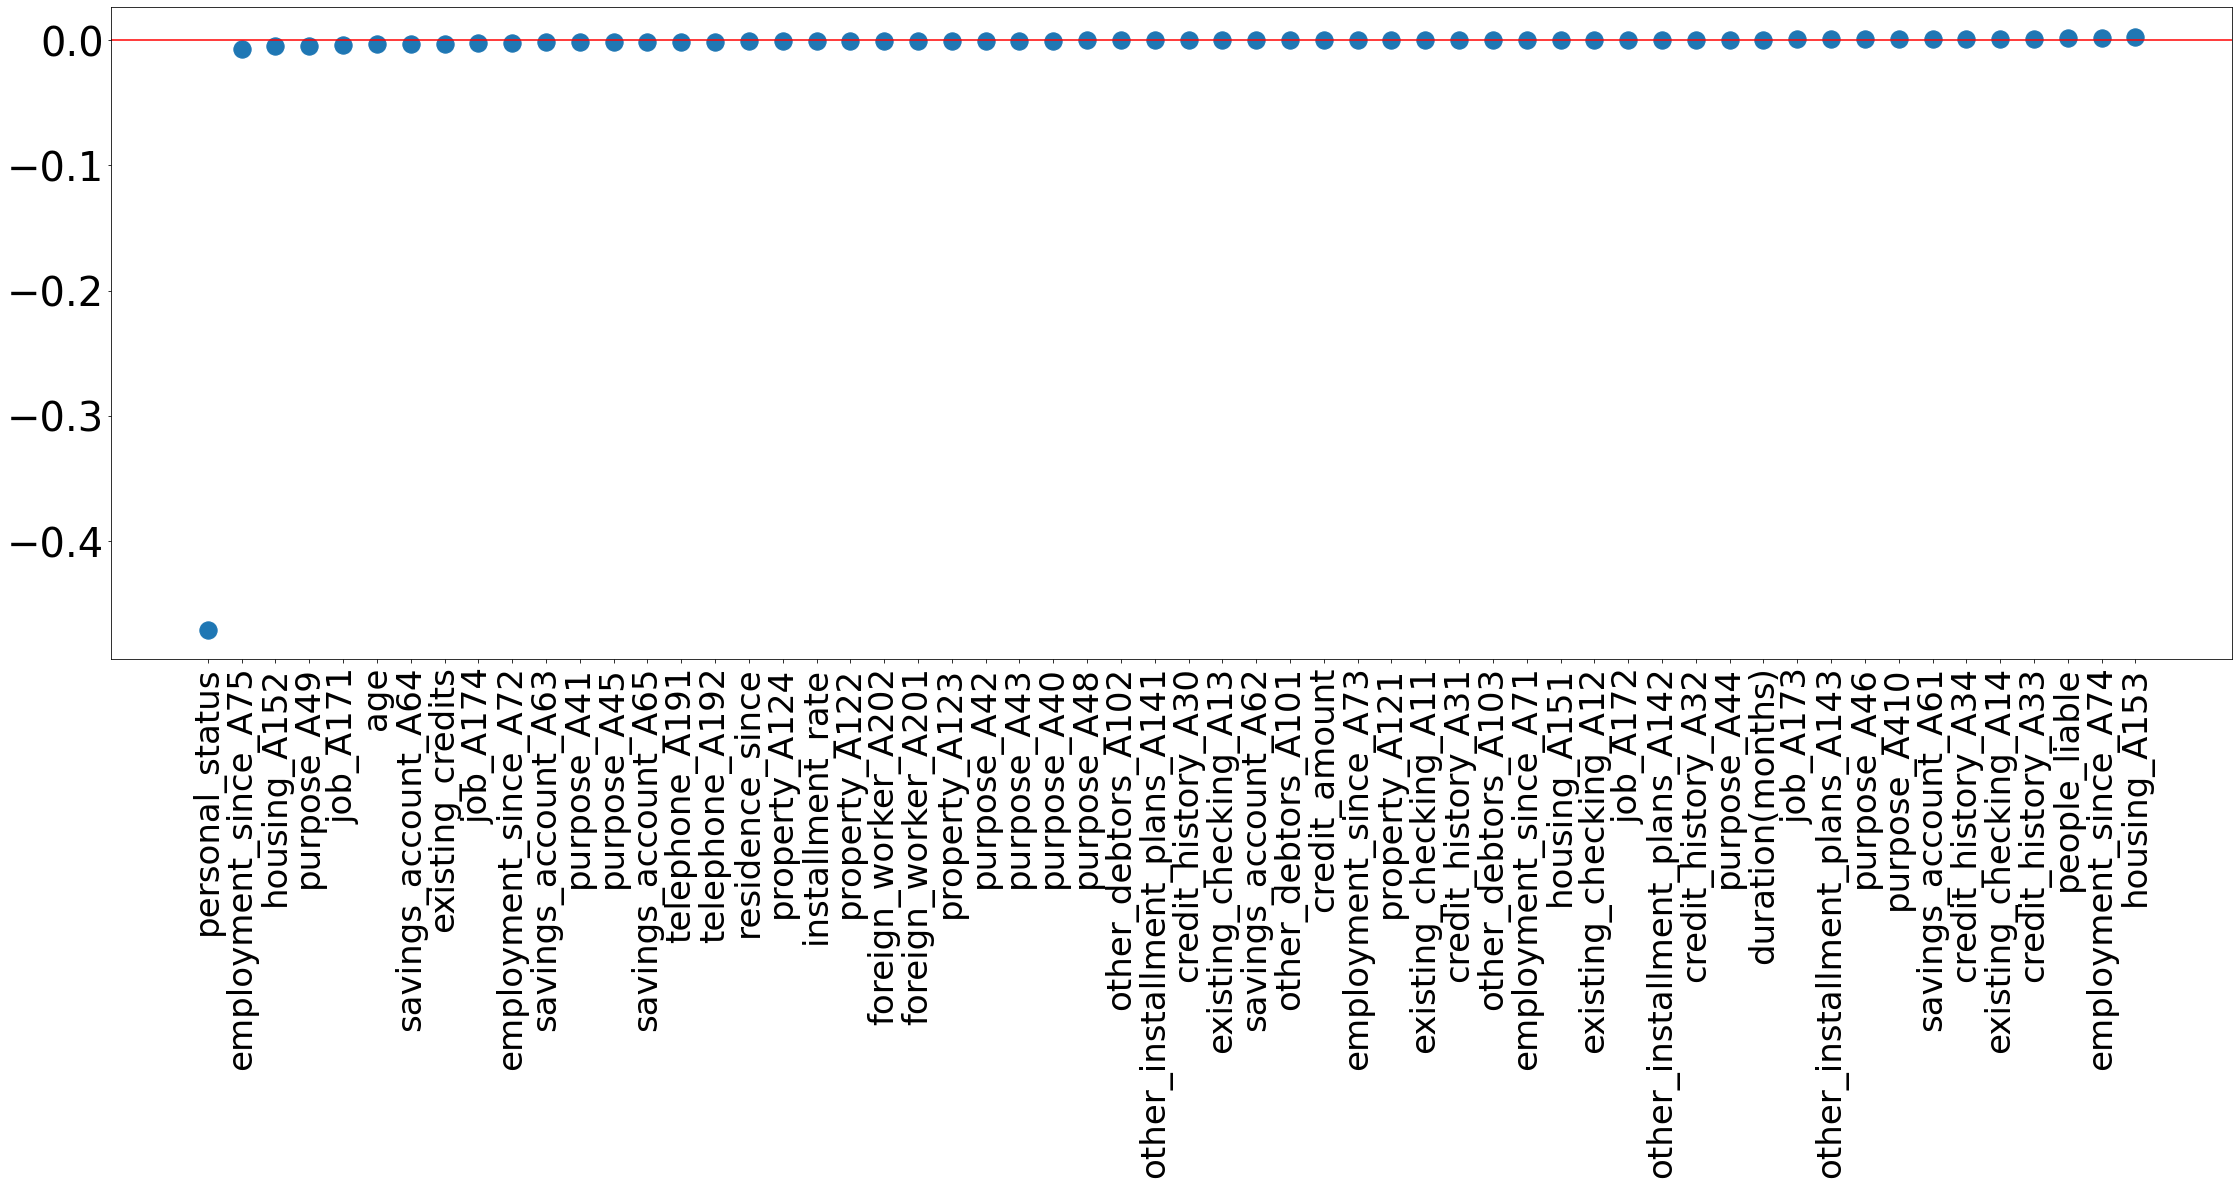

In [81]:
figure, ax = plt.subplots(figsize=(38,12))
ax.scatter(np.array(sorted_diff.index), sorted_diff['feature contribution'], s=300)
xticks_labels = np.array(sorted_diff.index)
plt.yticks(fontsize=32)
ax.set_xticklabels(xticks_labels, rotation=90, fontsize=34)
plt.yticks(fontsize=40)
ax.axhline(y=0, color="red")
plt.show()

We see that personal status is the only feature whose contributions to the difference in models is measurable, which is the same feature that our first approach indicated contributed the most to changes in $p\%$. All other features exhibited negligible contributions using this approach.